# Academy Award for Best Director

In [0]:
# Import packages
import pandas as pd
from datetime import datetime
from dateutil.relativedelta import relativedelta
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# Load the csv files into dataframes
bestdir_url = 'https://raw.githubusercontent.com/dcetin/academy-awards/master/best-director.csv?token=AD32IFU2AOHUJYINTWTU2N25Q2VF4'
ceremonies_url = 'https://raw.githubusercontent.com/dcetin/academy-awards/master/ceremonies.csv?token=AD32IFUN4ABRXTMM4YAEKHK5Q2VGU'
bestdir_df = pd.read_csv(bestdir_url)
ceremonies_df = pd.read_csv(ceremonies_url)
ceremonies_df.tail()

,Ceremony,Date
86,87,"February 22, 2015"
87,88,"February 28, 2016"
88,89,"February 26, 2017"
89,90,"March 04, 2018"
90,91,"February 24, 2019"


In [0]:
def get_ceremony_date(ceremonies_df, i):
  return ceremonies_df.iloc[ceremonies_df[ceremonies_df['Ceremony'] == i].index[0]]['date_dt']
def get_age(ceremonies_df, ceremony, birthdate, fmt='days'):
  if fmt == 'days':
    return (get_ceremony_date(ceremonies_df, ceremony) - birthdate).days
  elif fmt == 'str':
    rd = relativedelta(get_ceremony_date(ceremonies_df, ceremony), birthdate)
    return '{}y{}m{}d'.format(rd.years, rd.months, rd.days)
  elif fmt == 'float':
    rd = relativedelta(get_ceremony_date(ceremonies_df, ceremony), birthdate)
    return rd.years + (rd.months)/12.0 + (rd.days)/365.0

In [4]:
# Convert dates into datetime objects, append them as new columns
ceremonies_df['date_dt'] = pd.to_datetime(ceremonies_df['Date'].values, format='%B %d, %Y')
bestdir_df['birthdate_dt'] = pd.to_datetime(bestdir_df['Birthdate'].values, format='%B %d, %Y')
# Calculate ages, append them as new columns
bestdir_df['age_str'] = bestdir_df.apply(lambda row: get_age(ceremonies_df, row['Ceremony'], row['birthdate_dt'], fmt='str'), axis=1)
bestdir_df['age_days'] = bestdir_df.apply(lambda row: get_age(ceremonies_df, row['Ceremony'], row['birthdate_dt'], fmt='days'), axis=1)
bestdir_df['age_float'] = bestdir_df.apply(lambda row: get_age(ceremonies_df, row['Ceremony'], row['birthdate_dt'], fmt='float'), axis=1)
bestdir_df.tail()

,Ceremony,Won,Film,Director,Birthdate,birthdate_dt,age_str,age_days,age_float
448,91,False,BlacKkKlansman,Spike Lee,"March 20, 1957",1957-03-20,61y11m4d,22621,61.927626
449,91,False,Cold War,Pawel Pawlikowski,"September 15, 1957",1957-09-15,61y5m9d,22442,61.441324
450,91,False,The Favourite,Yorgos Lanthimos,"September 23, 1973",1973-09-23,45y5m1d,16590,45.419406
451,91,True,Roma,Alfonso Cuaron,"November 28, 1961",1961-11-28,57y2m27d,20907,57.240639
452,91,False,Vice,Adam McKay,"April 17, 1968",1968-04-17,50y10m7d,18575,50.852511


In [0]:
nominees = bestdir_df['Won'] == False
winners = bestdir_df['Won'] == True
ages_per_ceremony = [bestdir_df['age_float'][bestdir_df['Ceremony']==i].values for i in range(1, len(ceremonies_df)+1)]
means = np.asarray([np.mean(x) for x in ages_per_ceremony])
stds = np.asarray([np.std(x) for x in ages_per_ceremony])

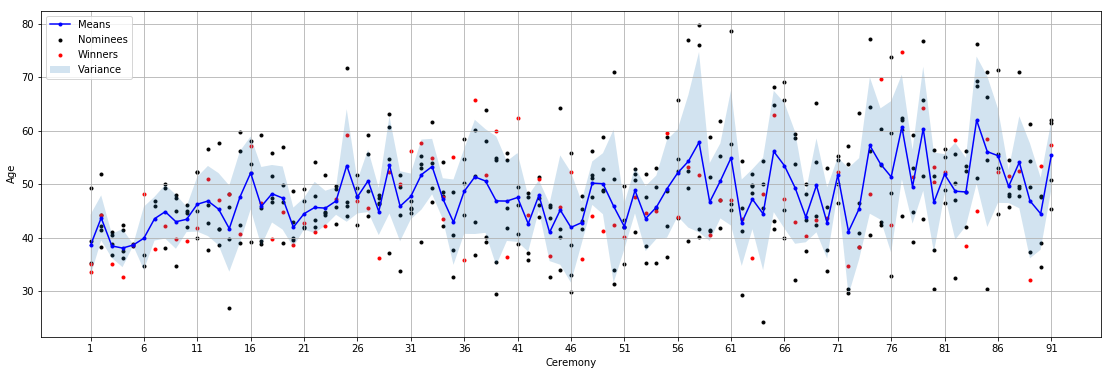

In [6]:
plt.figure(figsize=(19,6))
plt.scatter(bestdir_df['Ceremony'][nominees], bestdir_df['age_float'][nominees], marker='.', c='k', label='Nominees')
plt.scatter(bestdir_df['Ceremony'][winners], bestdir_df['age_float'][winners], marker='.', c='r', label='Winners')
plt.plot(ceremonies_df['Ceremony'], means, marker='.', c='b', label='Means')
plt.fill_between(ceremonies_df['Ceremony'], means-stds, means+stds, alpha=0.2, label='Variance')
plt.xticks(range(1, len(ceremonies_df)+1, 5))
plt.grid(True)
plt.ylabel('Age')
plt.xlabel('Ceremony')
plt.legend(loc='upper left')
plt.show()